In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt #To visualize the data
from PIL import Image  # To load image data to Python
#import scipy.ndimage as nd #To perform preprocessing on image data
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms as T, datasets
from helper import view_classify, show_image, show_grid, accuracy
import torch.nn.functional as F
import timm
from torchsummary import summary


In [245]:
# Making the 1st Class Called Configuration
class CFG:

    epochs = 4                                         # No. of epochs of training the model -- We are going to run this EPOCH during the training Loop -- how many                                                   # times we are going to run the training loop!
    lr = 0.001    # Learning rate --
    batch_size = 4                                     # Batch Size For Dataset #number of samples that give simultaneously
                                                       # pictures you take at once

    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)

    img_size = 200

    # Going to be use for loading dataset
    DATA_DIR = "Y:/Python-Projects/Neural Systems/localCode/data/"                       # Data Directory
    TEST = 'test'                                      # Test folder name in data directory
    TRAIN = 'train'                                    # Train folder name in data directory
    VAL ='val'                                         # Valid folder name in data directory
                                                       # validation set is the separated part of train set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # we are going to use CPU

print("On which device we are on : {}".format(device))

On which device we are on : cpu


**Explanation of Class Configuration**
Epoch:  The more epoch it has the more effectively train will. Training for more epochs allows the network to learn more patterns and improve its performance over time
lr: Hyper Parameter that controls how quickly or slow learns:  models parameter or Weights are updated during the training process
batch_size: # of training samples in a single batch  ...  1 epoch =  many batches
model_name : Timm --> efficientNet
img_size: variable for size of the images for resizing transformations for train/ val/ test


In [246]:
# TRANSFORMING THE DATA
train_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-30,+30)),  # random between +/- 30 degrees
    T.ToTensor(),
    T.RandomInvert(),
    # T.Grayscale(num_output_channels=1),
    # T.Normalize([0.5], [0.4]),              # normalizing for Grayscale
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # normalizing each color channel (red/ green/ blue) CxHxW, [mean] + [standard deviation]
])

valid_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([

    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [247]:

import os
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))
total = len(trainset)+len(validset)+len(testset)
print("Total :",total)

Trainset Size : 5051
Validset Size : 181
Testset Size : 624
Total : 5856


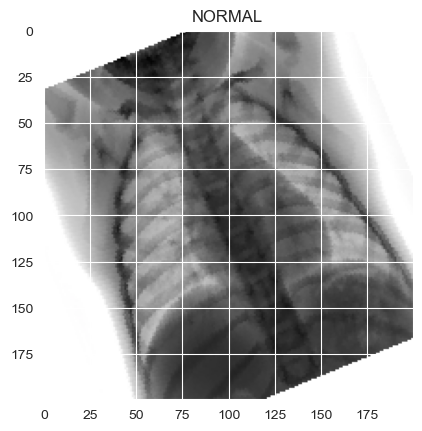

In [248]:
image, label = trainset[2]

class_names = ['NORMAL','PNEUMONIA']

show_image(image,class_names[label])



In [249]:
# Load Data Set into Batches #
trainloader = DataLoader(trainset, batch_size = CFG.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size , shuffle = True)

print("Number of batches in Train Loader : {}".format(len(trainloader)))
print("Number of batches in Valid Loader : {}".format(len(validloader)))
print("Number of batches in Test Loader : {}".format(len(testloader)))
print("Number of Total samples : {}".format(len(trainloader.dataset)))

Number of batches in Train Loader : 1263
Number of batches in Valid Loader : 46
Number of batches in Test Loader : 156
Number of Total samples : 5051


In [262]:
dataiter = iter(trainloader) # create an iterator : every time we make a prediction // every time the network weights are updated
images, labels = next(dataiter)

out = make_grid(images,nrow=16)

show_grid(out, title=[class_names[x] for x in labels])

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

Fine Tuning and **EFFICIENT NET MODEL**
updating last layer as classifier  > linear layer that takes 1792 features in and 1000 claasses in the imagenet (out)
Read summary 



In [251]:
#creating a sequential model / used to compute the output of each neuron
model = timm.create_model(CFG.model_name, pretrained = True)
# timm --> efficient net --> pretrained model
for param in model.parameters():
    param.requires_grad = False #freezing the part of the model as no changes happen to its parameters

# modifies the classifier part of the model's architecture. It replaces the existing classifier 
# with a new sequence of layers defined within the nn.Sequential() container.

model.classifier = nn.Sequential(
        # multiclass Classification
        nn.Linear(in_features = 1792, out_features = 625),  # 1792 is the label tensor output of efficientNet
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features = 625, out_features = 246),
        nn.ReLU(), #Activation Layer
        # nn.MaxPool2d(2, 2),
        nn.Linear(in_features = 246, out_features = 2)  # out=2 for cross criterion - out=1 for binary

)

model.to(device) # only for GPU


#summary (model, input_size = (3,224,224))

C:\Users\tohim\miniconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

**Building a Trainer** 
Cross-entropy loss : SOFT max function ... loss function in PyTorch for training classification models : measures the difference between the **predicted class probabilities** and the **true class lables**

In [252]:
# Building a Trainer

class PneumoniaTrainer():
    
    def __init__(self,criterion = None, optimizer = None,schedular = None):
        # here input for criterion/ optimizer is None because we initiate the model with
        # empty inputs and add the criterion and optimizer
        self.criterion = criterion # loss function
        self.optimizer = optimizer # adjust the parameters in order to minimize the loss function 
        self.schedular = schedular # adjusting the learning rate during the training process
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
    
    def train_batch_loop(self, model, trainloader):
        
        train_loss = 0.0
        train_acc = 0.0

        
        for images,labels in tqdm(trainloader):     # tqdm gives back iteratable objects
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images) # use the pytorch  cross entropy loss
                                   # logits: tensor called logits that comes out of the pretrained model --> to put it into our own model
                                   # logit: output of effectiveNet that is put into our model (our layers)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad() # gradient = 0 (when start training gradients need to be zero)
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()   # train_loss is 1 array of numbers - loss.item is the actual loss calculated
                                        # sums up batch losses until it has loss of whole model
            train_acc += accuracy(logits,labels)

        self.train_accuracy_history.append(train_acc)
        self.train_loss_history.append(train_loss)
            
        return train_loss / len(trainloader), train_acc / len(trainloader)

    
    def valid_batch_loop(self, model, validloader):

        valid_loss = 0.0
        valid_acc = 0.0


        for images, labels in tqdm(validloader):    # tqdm gives back iteratable objects

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits,labels)

            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)

        self.val_accuracy_history.append(valid_acc)
        self.val_loss_history.append(valid_loss)

        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'PneumoniaModel_4.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [253]:
#Training the model

criterion = nn.CrossEntropyLoss() # for binary classification: nn.BCEWithLogitsLoss() - here only 1 output from layers
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
print(trainer.val_loss_history, trainer.train_loss_history, trainer.val_accuracy_history, trainer.train_loss_history)
trainer.fit(model, trainloader, validloader, epochs = CFG.epochs)  # fitting expected model data to real data

[] [] [] []


100%|██████████| 46/46 [00:12<00:00,  3.80it/s]


Valid_loss decreased inf --> 0.3535579455935437
Epoch : 1 Train Loss : 0.391745 Train Acc : 0.828583
Epoch : 1 Valid Loss : 0.353558 Valid Acc : 0.842391


100%|██████████| 46/46 [00:12<00:00,  3.81it/s]


Epoch : 2 Train Loss : 0.332899 Train Acc : 0.861243
Epoch : 2 Valid Loss : 0.411492 Valid Acc : 0.836957


100%|██████████| 46/46 [00:12<00:00,  3.80it/s]


Epoch : 3 Train Loss : 0.328301 Train Acc : 0.863025
Epoch : 3 Valid Loss : 0.406101 Valid Acc : 0.826087


100%|██████████| 46/46 [00:12<00:00,  3.71it/s]

Valid_loss decreased 0.3535579455935437 --> 0.33200603064893663
Epoch : 4 Train Loss : 0.315465 Train Acc : 0.868501
Epoch : 4 Valid Loss : 0.332006 Valid Acc : 0.847826


100%|██████████| 156/156 [00:40<00:00,  3.85it/s]

Test Loss : 0.45229254874478403
Test Acc : 0.7964743375778198


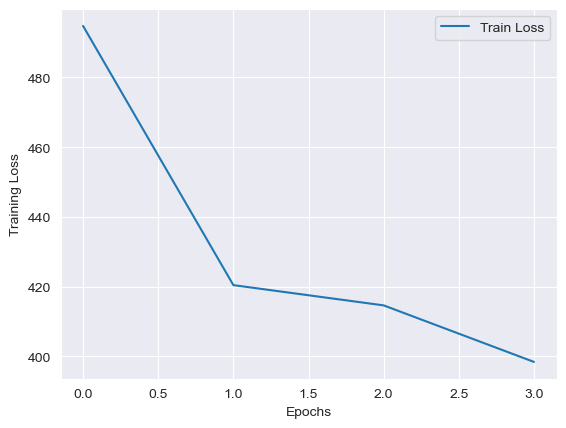

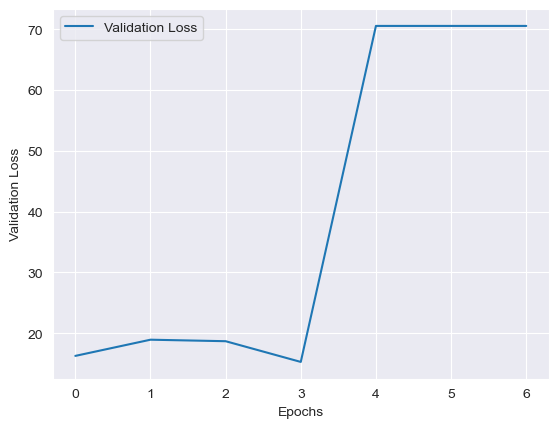

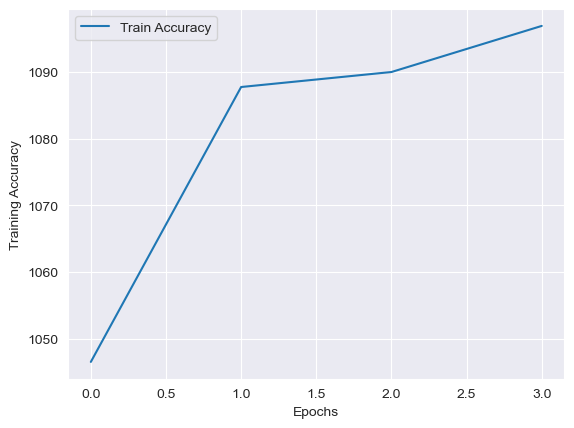

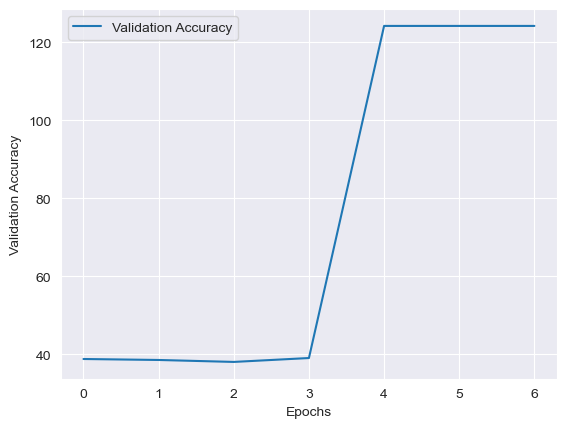

In [257]:
#Plot Results 

model.load_state_dict(torch.load('PneumoniaModel_4.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

# Plot the learning curve (loss)

# for j in range(1):      # if we have more models then we could iterate through all models here and plot it
#     loss = trainer.train_loss_history
#     val_loss = trainer.val_loss_history
#
#     plt.title("For CNN: "+ str(j+1))
#     plt.plot(range(len(loss)),loss, label = 'Training_loss')
#     plt.plot(range(len(val_loss)),val_loss, label = 'Validation_loss')
#     plt.ylabel('loss')
#     plt.xlabel('epochs')
#     plt.legend()
#     plt.show()

plt.plot(trainer.train_loss_history, label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

plt.plot(trainer.val_loss_history, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

# for j in range(1):
#     accs = trainer.train_accuracy_history
#     val_accs = trainer.val_accuracy_history
#
#     plt.title("For CNN: "+ str(j+1))
#     plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
#     plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epochs')
#     plt.legend()
#     plt.show()

plt.plot(trainer.train_accuracy_history, label='Train Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

plt.plot(trainer.val_accuracy_history, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

# First Model (Pneumonia_1)
# Test Loss : 0.3145880794359578
# Test Acc : 0.8738096356391907

# Second Model (Pneumonia_2)
# Test Loss : 0.2707478477834509
# Test Acc : 0.8990384340286255

# Second Model 2nd run
# Test Loss : 0.31228102046327716
# Test Acc : 0.8573718070983887

# Third Model (Pneumonia_3)
# Test Loss : 0.4642532324561706
# Test Acc : 0.746795117855072

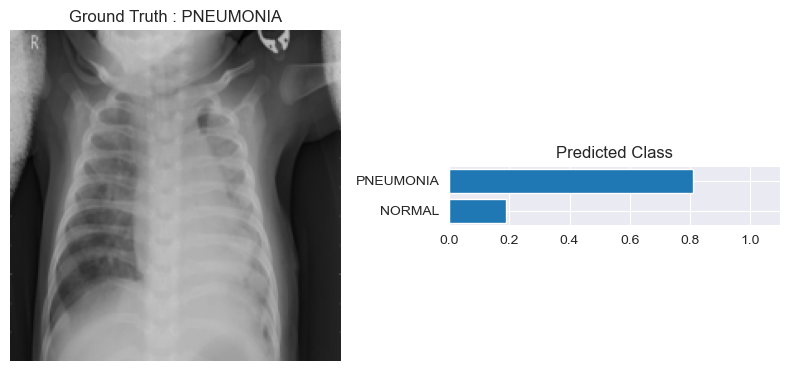

In [258]:

image,label = testset[365]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)      # rescaling - every pixel [value 0-1] is some percentage of the whole (adding all up is 1)

view_classify(image,ps,label)